## 足球比赛盘口信息分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab    
import matplotlib.pyplot as plt  
import datetime
import pickle
import time
import tqdm

import sys
import os

### 比赛结果分布分析

In [2]:
column_names = ['match_id', 'home_socre_ft', 'away_score_ft', 'update_time', 'flag']
df_result = pd.read_table('../raw_data/nowgoal_result.txt', sep=',', usecols=[0, 5, 6, 9, 10], names=column_names)
df_result.update_time = pd.to_datetime(df_result.update_time, format="%Y/%m/%d %H:%M:%S")
match_ids = df_result.match_id.values
df_result.head(2)

,match_id,home_socre_ft,away_score_ft,update_time,flag
0,1361100,2,3,2017-06-21 15:46:35,7
1,1337164,5,0,2017-06-21 15:48:32,7


一共有 39276 场比赛, 胜利分布：主队-17720, 客队-11500, 平局-10056


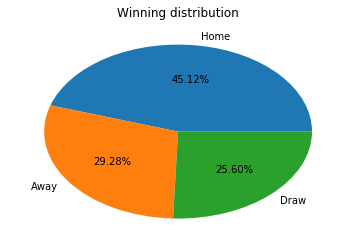

In [3]:
n_match = len(df_result)  # 比赛场数
home_score_ft = df_result.home_socre_ft.values
away_score_ft = df_result.away_score_ft.values
scores = zip(home_score_ft, away_score_ft)

n_home_win = sum(map(lambda s: s[0] > s[1], scores))
n_away_win = sum(map(lambda s: s[1] > s[0], scores))
n_draw = sum(map(lambda s: s[1] == s[0], scores))
print('一共有 %d 场比赛, 胜利分布：主队-%d, 客队-%d, 平局-%d' % (n_match, n_home_win, n_away_win, n_draw))

labels=['Home','Away','Draw']  
X=[n_home_win, n_away_win, n_draw]    

fig = plt.figure()  
plt.pie(X, labels=labels, autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）  
plt.title("Winning distribution")  
plt.show()    

#### 获胜球数分布

主队最多赢球 15, 最多输球 -15, 平均赢球 1.8724, 平均输球数-1.7307


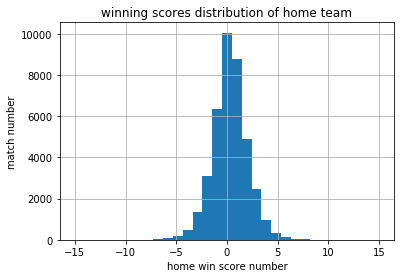

In [4]:
win_scores = map(lambda s: s[0] - s[1], scores)  # 主队赢球个数
home_win_scores = filter(lambda score: score > 0, win_scores)
away_win_scores = filter(lambda score: score < 0, win_scores )
max_win_score = max(win_scores)
max_loss_score = min(win_scores)
mean_win_score = np.mean(home_win_scores)   # 平均赢球数
mean_loss_score = np.mean(away_win_scores)  # 平均输球数
print('主队最多赢球 %d, 最多输球 %d, 平均赢球 %g, 平均输球数%g' % (
    max_win_score, max_loss_score, mean_win_score, mean_loss_score))

# 赢球个数分布
plt.hist(win_scores, bins=max_win_score-max_loss_score+1, range=(max_loss_score, max_win_score))
plt.xlabel('home win score number')
plt.ylabel('match number')
plt.title('winning scores distribution of home team')
plt.grid()
plt.show()

### 胜平负赔率信息分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab    
import matplotlib.pyplot as plt  
import datetime
import pickle
import time
from tqdm import tqdm 

import sys
import os

In [2]:
column_names = ['match_id', 'bookmaker_id', 'time', 'Home', 'Draw', 'Away', 'update_time', 'status']
df_euro_all = pd.read_table('../raw_data/nowgoal_euro.txt', sep=',', usecols=[0, 1, 2, 4, 5, 6, 7, 8], names=column_names)
df_euro_all.update_time = pd.to_datetime(df_euro_all.update_time, format="%Y/%m/%d %H:%M:%S")
df_euro_all.head(3)

/home/peng/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,match_id,bookmaker_id,time,Home,Draw,Away,update_time,status
0,1361100,24,89,NaN,Closed,NaN,2017-06-20 00:48:17,Run
1,1361100,24,75,90.0,8.20,1.09,2017-06-20 00:33:59,Run
2,1361100,24,73,69.0,7.90,1.10,2017-06-20 00:32:04,Run


一共有 3 个庄家。
- 统计每场比赛在比赛前和比赛中一共用多少次赔率变化。
- 统计赔率变化的时间点距离比赛开始的时间分布。（首先把时间转为距离比赛开始的时间）
- 统计比赛开始以后赔率变化的时间点分布

In [ ]:
# # 多列筛选
# df_euro_all[(df_euro_all.match_id == 1371499) & (df_euro_all.bookmaker_id == 31)].iloc[:3, :]

In [41]:
def change_distribute(df_euro):
    """df_enro: 某个庄家的赔率信息变化。"""
    df_matches = df_euro.groupby(['match_id'])
    n_changes = list()  # 每场比赛中赔率的变化次数
    update_time_from_begin = list()  # 赔率变化时刻距离比赛开始的时间
    for name, df_match in df_matches:
        n_change = len(df_match)
        n_changes.append(n_change)
        # 获取比赛开赛时间
        df_match = df_match.sort_values(by='update_time', ascending=False)
        df_run = df_match[df_match.status == 'Run'].copy()
        if len(df_run) > 0:
            last_time = df_run.iloc[-1].time
            start_time = df_run.iloc[-1].update_time
            try:
                last_time = float(last_time)
            except:
                continue
            # 把时间处理成距离比赛时间 (min)
            df_match.update_time = df_match.update_time.apply(lambda up_time: int((up_time-start_time).total_seconds() / 60) - last_time)
            update_time = df_match.update_time.values.tolist()
            max_up_time = max(update_time)
            if max_up_time > 200:  # 超过比赛开始 200分钟 认为是异常值
                continue
            update_time_from_begin.append(update_time)

    print('比赛场数（不同庄家算不同场数）=%d' % len(n_changes))
#     print('赔率变化次数示例:%s' % str(n_changes[:10]))
#     print('变化时间示例:%s' % str(update_time_from_begin[0]))
    
    # 赔率变化次数分布
    max_n_change = max(n_changes)
    min_n_change = min(n_changes)
    mean_n_change = np.mean(n_changes)
    median_n_change = np.median(n_changes) 
    print('change number: max=%d, min=%d, mean=%d, median=%d' % (
        max_n_change, min_n_change, mean_n_change, median_n_change))
 
    plt.hist(n_changes, bins=300, range=(0, 299))
    plt.xlabel('changes number')
    plt.ylabel('match number')
    plt.title('the distribution of odds changing number')
    plt.grid()
    plt.show()
    return update_time_from_begin

def odds_change_time(update_time_from_begin, bookmaker_id, x_range=(-1000, 500)):
    plt.hist(update_time_from_begin, bins=x_range[1] - x_range[0], range=x_range, alpha=0.5, label=bookmaker_id)   

庄家 8 
比赛场数（不同庄家算不同场数）=27698
change number: max=4032, min=1, mean=28, median=9


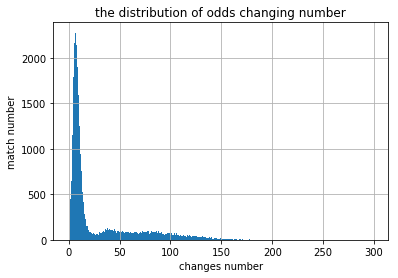

min update time: -187546, max update time: 200
庄家 24 
比赛场数（不同庄家算不同场数）=27060
change number: max=27694, min=1, mean=81, median=50


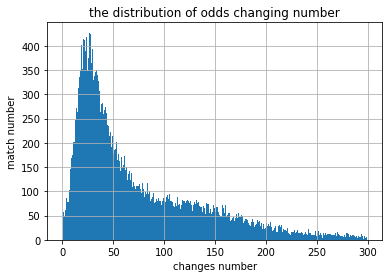

min update time: -125662, max update time: 196
庄家 31 
比赛场数（不同庄家算不同场数）=26396
change number: max=25788, min=1, mean=71, median=29


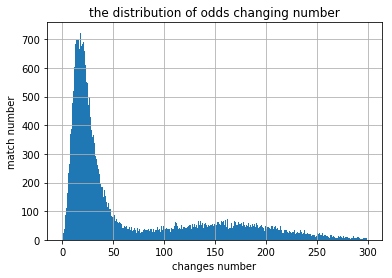

min update time: -127068, max update time: 146


In [4]:
from itertools import  chain

df_euros = df_euro_all.groupby(['bookmaker_id'])
euro_update_time_from_begins = list()
for name, df_euro in df_euros:
    print('庄家 %s ' % name)
    euro_update_time_from_begin = change_distribute(df_euro)
    euro_update_time_from_begin = list(chain(*euro_update_time_from_begin))
    print('min update time: %g, max update time: %g' % (np.min(euro_update_time_from_begin), np.max(euro_update_time_from_begin)))
    euro_update_time_from_begins.append(euro_update_time_from_begin)

赔率变化时刻距离开赛时间分布

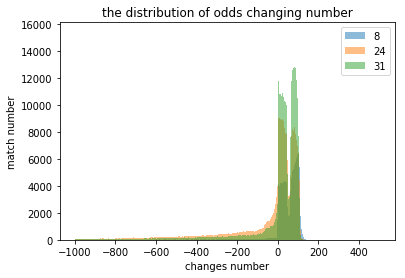

In [5]:
bookmaker_ids = ['8', '24', '31']
for i in xrange(len(euro_update_time_from_begins)):
    odds_change_time(euro_update_time_from_begins[i], bookmaker_ids[i])
plt.xlabel('changes number')
plt.ylabel('match number')
plt.title('the distribution of odds changing number')
plt.grid()
plt.legend()
plt.grid()
plt.show()

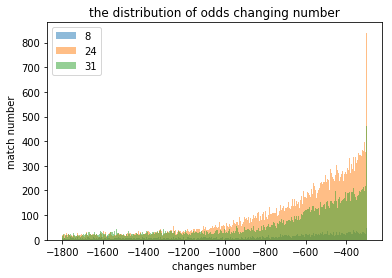

In [7]:
bookmaker_ids = ['8', '24', '31']
for i in xrange(len(euro_update_time_from_begins)):
    odds_change_time(euro_update_time_from_begins[i], bookmaker_ids[i], x_range=(-1800, -300))
plt.xlabel('changes number')
plt.ylabel('match number')
plt.title('the distribution of odds changing number')
plt.grid()
plt.legend()
plt.grid()
plt.show()


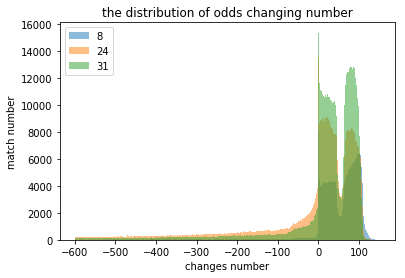

In [8]:
bookmaker_ids = ['8', '24', '31']
for i in xrange(len(euro_update_time_from_begins)):
    odds_change_time(euro_update_time_from_begins[i], bookmaker_ids[i], x_range=(-600, 150))
plt.xlabel('changes number')
plt.ylabel('match number')
plt.title('the distribution of odds changing number')
plt.grid()
plt.legend()
plt.grid()
plt.show()

**胜平负赔率变化分析方法与结果：** 上图表示了从数据库中抓取的三个庄家的胜平负赔率变化的时间分布，其中 0 表示比赛开始的时刻，负数表示比赛开始前的赔率变化，正数表示开赛后的赔率变化。具体的处理方式为：
- 比赛开始时刻：在 run 状态的赔率信息中，字段 time 表示比赛进行到第几分钟。通过对所有 run 状态的信息按照时间 降序 排序，取最后一个时刻，也就是比赛开始以后第一个赔率信息。把该时刻对应的时间减去当时所处比赛第几分钟，得到比赛的开始时刻。
- 异常数据处理：把比赛开始后超过 200 分钟依然还有赔率变化的比赛数据弃掉，一般比赛90分钟+中场15分钟+补时，不会超过200分钟。

从上图的结果来看，开赛前的20小时以前，赔率数据基本没什么变化，在赛前20小时开始，赔率变化增加。在开赛前的一个小时，赔率开始频繁变化。在比赛的过程中，比赛变化更加频繁。不同庄家的变化情况也有较大的区别。

## 盘口赔率

In [40]:
column_names = ['match_id', 'bookmaker_id', 'time', 'Home', 'handicap', 'Away', 'update_time', 'status']
df_handicap_all = pd.read_table('../raw_data/nowgoal_handicap.txt', sep=',', usecols=[0, 1, 2, 4, 5, 6, 7, 8], names=column_names)
df_handicap_all.update_time = pd.to_datetime(df_handicap_all.update_time, format="%Y/%m/%d %H:%M:%S")
df_handicap_all.head(3)

,match_id,bookmaker_id,time,Home,handicap,Away,update_time,status
0,1361100,24,92,NaN,Closed,NaN,2017-06-20 00:51:17,Run
1,1361100,24,92,1.96,0,0.43,2017-06-20 00:50:58,Run
2,1361100,24,92,2.22,0,0.37,2017-06-20 00:50:50,Run


In [43]:
# 部分信息中 handicap 不是一个值，需要进行转化
def change_handicap(handicap):
    if '/' in handicap:
        handicaps = handicap.split('/')
        return (float(handicaps[0]) + float(handicaps[1])) / 2.0 + 1.0
    else:
        try:
            handicap = float(handicap)
        except:
            return handicap

df_handicap_all.handicap = df_handicap_all.handicap.apply(change_handicap)
df_handicap_all.Home = df_handicap_all.Home.apply(lambda home: home+1.0)
df_handicap_all.Away = df_handicap_all.Away.apply(lambda away: away+1.0)
df_handicap_all.head(3)

,match_id,bookmaker_id,time,Home,handicap,Away,update_time,status
0,1361100,24,92,NaN,Closed,NaN,2017-06-20 00:51:17,Run
1,1361100,24,92,2.96,None,1.43,2017-06-20 00:50:58,Run
2,1361100,24,92,3.22,None,1.37,2017-06-20 00:50:50,Run


庄家 8 
比赛场数（不同庄家算不同场数）=16904
change number: max=275, min=1, mean=52, median=40


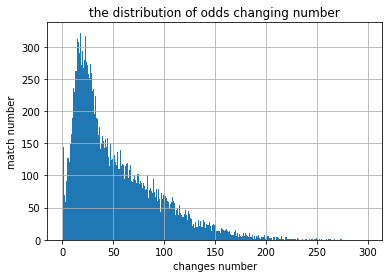

min update time: -126557, max update time: 198
庄家 24 
比赛场数（不同庄家算不同场数）=16716
change number: max=805, min=1, mean=85, median=67


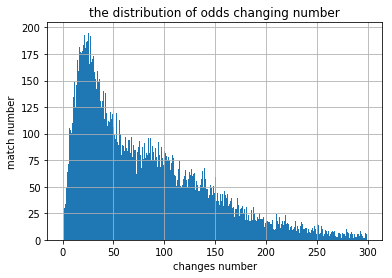

min update time: -126058, max update time: 198
庄家 31 
比赛场数（不同庄家算不同场数）=16214
change number: max=362, min=1, mean=61, median=39


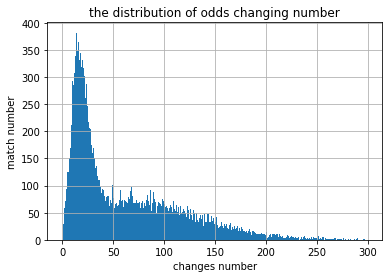

min update time: -127068, max update time: 199


In [44]:
df_handicaps = df_handicap_all.groupby(['bookmaker_id'])
handicap_update_time_from_begins = list()
for name, df_handicap in df_handicaps:
    print('庄家 %s ' % name)
    handicap_update_time_from_begin = change_distribute(df_handicap)
    handicap_update_time_from_begin = list(chain(*handicap_update_time_from_begin))
    print('min update time: %g, max update time: %g' % (np.min(handicap_update_time_from_begin), np.max(handicap_update_time_from_begin)))
    handicap_update_time_from_begins.append(handicap_update_time_from_begin)

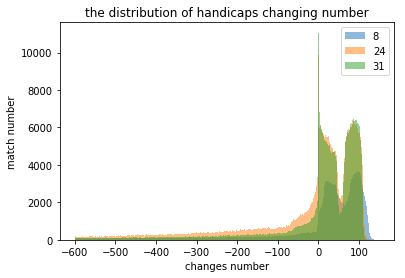

In [45]:
bookmaker_ids = ['8', '24', '31']
for i in xrange(len(handicap_update_time_from_begins)):
    odds_change_time(handicap_update_time_from_begins[i], bookmaker_ids[i], x_range=(-600, 150))
plt.xlabel('changes number')
plt.ylabel('match number')
plt.title('the distribution of handicaps changing number')
plt.grid()
plt.legend()
plt.grid()
plt.show()

## 大小球

In [46]:
column_names = ['match_id', 'bookmaker_id', 'time', 'Over', 'overunder', 'Under', 'update_time', 'status']
df_overunder_all = pd.read_table('../raw_data/nowgoal_overunder.txt', sep=',', usecols=[0, 1, 2, 4, 5, 6, 7, 8], names=column_names)
df_overunder_all.update_time = pd.to_datetime(df_overunder_all.update_time, format="%Y/%m/%d %H:%M:%S")
df_overunder_all.head(3)

,match_id,bookmaker_id,time,Over,overunder,Under,update_time,status
0,1361100,24,93,9.09,5.5,0.03,2017-06-20 00:52:01,Run
1,1361100,24,93,8.33,5.5,0.04,2017-06-20 00:51:46,Run
2,1361100,24,93,9.09,5.5,0.03,2017-06-20 00:51:35,Run


In [50]:
# 部分信息中 handicap 不是一个值，需要进行转化
df_overunder_all.overunder = df_overunder_all.overunder.apply(change_handicap)
df_overunder_all.Over = df_overunder_all.Over.apply(lambda over: over+1.0)
df_overunder_all.Under = df_overunder_all.Under.apply(lambda under: under+1.0)
df_overunder_all.head(3)

,match_id,bookmaker_id,time,Over,overunder,Under,update_time,status
0,1361100,24,93,10.09,None,1.03,2017-06-20 00:52:01,Run
1,1361100,24,93,9.33,None,1.04,2017-06-20 00:51:46,Run
2,1361100,24,93,10.09,None,1.03,2017-06-20 00:51:35,Run


庄家 8 
比赛场数（不同庄家算不同场数）=27521
change number: max=550, min=1, mean=45, median=17


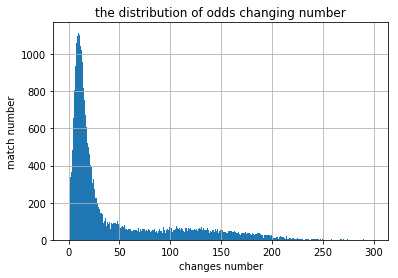

min update time: -126559, max update time: 198
庄家 24 
比赛场数（不同庄家算不同场数）=27281
change number: max=951, min=1, mean=62, median=24


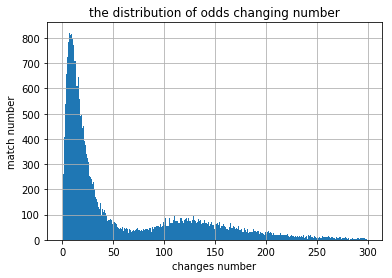

min update time: -126061, max update time: 199
庄家 31 
比赛场数（不同庄家算不同场数）=26549
change number: max=386, min=1, mean=52, median=11


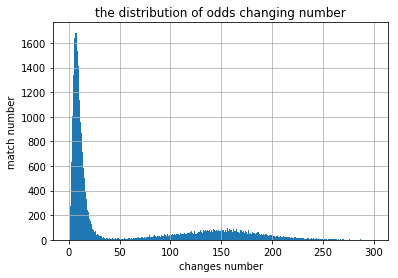

min update time: -127068, max update time: 172


In [51]:
df_overunders = df_overunder_all.groupby(['bookmaker_id'])
overunder_update_time_from_begins = list()
for name, df_overunder in df_overunders:
    print('庄家 %s ' % name)
    overunder_update_time_from_begin = change_distribute(df_overunder)
    overunder_update_time_from_begin = list(chain(*overunder_update_time_from_begin))
    print('min update time: %g, max update time: %g' % (np.min(overunder_update_time_from_begin), np.max(overunder_update_time_from_begin)))
    overunder_update_time_from_begins.append(overunder_update_time_from_begin)

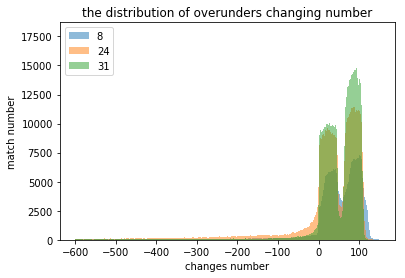

In [52]:
bookmaker_ids = ['8', '24', '31']
for i in xrange(len(overunder_update_time_from_begins)):
    odds_change_time(overunder_update_time_from_begins[i], bookmaker_ids[i], x_range=(-600, 150))
plt.xlabel('changes number')
plt.ylabel('match number')
plt.title('the distribution of overunders changing number')
plt.grid()
plt.legend()
plt.grid()
plt.show()

## 三种赔率变化的比较

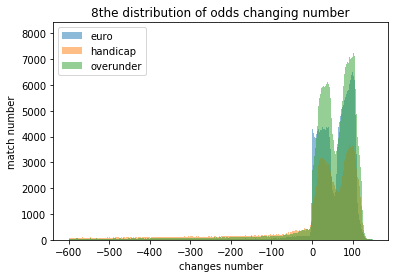

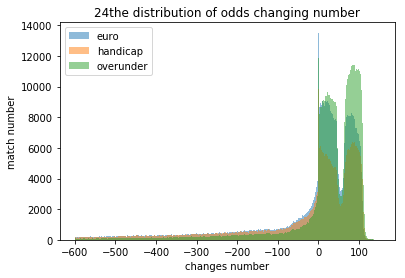

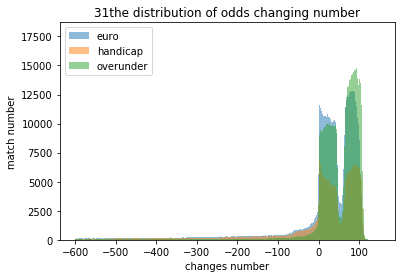

In [54]:
bookmaker_ids = ['8', '24', '31']
odds_types = ['euro', 'handicap', 'overunder']
euro_update_time_from_begins
handicap_update_time_from_begins
overunder_update_time_from_begins

for i in xrange(3):
    odds_change_time(euro_update_time_from_begins[i], 'euro', x_range=(-600, 150))
    odds_change_time(handicap_update_time_from_begins[i], 'handicap', x_range=(-600, 150))
    odds_change_time(overunder_update_time_from_begins[i], 'overunder', x_range=(-600, 150))
    plt.xlabel('changes number')
    plt.ylabel('match number')
    plt.title(str(bookmaker_ids[i]) + 'the distribution of odds changing number')
    plt.grid()
    plt.legend()
    plt.grid()
    plt.show()

从上面的结果可以看出：
- 在开赛之前，胜平负赔率变化最多，其次为盘口，再到大小球；
- 开赛以后，盘口赔率变化最少
- 中场以前，胜平负赔率变化最多；中场以后，大小球赔率变化最频繁。